# 02 Spanish Translation A/B Test
1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation cross Spain and LatAm performs better. 

2. Explain why that might be happening. Are the localized translations really worse?

3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results .can be trusted

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import os
import matplotlib.pyplot as plt
os.chdir(r"C:\Users\m3406\OneDrive\桌面\DS_Study\02 AB_Test")

In [2]:
# Get Data
url = "https://github.com/githubjasmine/DS-A_Collection_of_Take_Home_Challenges/raw/master/AB%20TESTING%20Spanish%20Translation%20with%20solution/test_table.csv"
df_test = pd.read_csv(url, parse_dates=[0])

url = "https://github.com/githubjasmine/DS-A_Collection_of_Take_Home_Challenges/raw/master/AB%20TESTING%20Spanish%20Translation%20with%20solution/user_table.csv"
df_user = pd.read_csv(url, parse_dates=[0])

In [3]:
# Generate Report
"""
report = ProfileReport(df_user.drop("user_id", axis = 1))
report.to_file("df_user.html")

report = ProfileReport(df_test.drop("user_id", axis = 1))
report.to_file("df_test.html")
"""

'\nreport = ProfileReport(df_user.drop("user_id", axis = 1))\nreport.to_file("df_user.html")\n\nreport = ProfileReport(df_test.drop("user_id", axis = 1))\nreport.to_file("df_test.html")\n'

In [4]:
# % of Users 
print("User age < 20 : ")
print(f"{100*len(df_user[df_user['age']<20])/len(df_user):.2f}%")
print("User age <= 20 : ")
print(f"{100*len(df_user[df_user['age']<=20])/len(df_user):.2f}%")

User age < 20 : 
11.62%
User age <= 20 : 
17.59%


# EDA

In [5]:
# Check ids in two tables
len(df_user["user_id"].unique()) - len(df_test["user_id"].unique())

-454

In [6]:
len(df_user["user_id"].unique()) - len(df_user)

0

In [7]:
len(df_test["user_id"].unique()) - len(df_test)

0

### note :
1. The Experiment only Tests 5 Days. 
2. Above 80% user set their browser language as ES. 
3. Overall Conversion rat is about 5.0%. (Imbalance)

In [8]:
# Check the cause of nan  
print("Source If Ads_channel is Null. ")
print(df_test.loc[df_test["ads_channel"].isnull(), "source"].unique())
print("-"*20)
print("Source If Ads_channel is not Null. ")
print(df_test.loc[~df_test["ads_channel"].isnull(), "source"].unique())


Source If Ads_channel is Null. 
['Direct' 'SEO']
--------------------
Source If Ads_channel is not Null. 
['Ads']


In [9]:
# Check Device & Browser Type
print(f'Web Browser Type : {df_test[df_test["device"] == "Web"]["browser"].unique()}')
print(f'Mobile Browser Type : {df_test[df_test["device"] == "Mobile"]["browser"].unique()}')

Web Browser Type : ['IE' 'Chrome' 'FireFox' 'Safari' 'Opera']
Mobile Browser Type : ['Android_App' 'Iphone_App']


In [10]:
# Adj na values in ad_column
df_test.loc[df_test["ads_channel"].isnull(), "ads_channel"] = "-"

df_all = pd.merge(df_test, df_user, how = "outer", on = "user_id")
"""
report = ProfileReport(df_all.drop("user_id", axis = 1))
report.to_file("df_all.html")
"""

'\nreport = ProfileReport(df_all.drop("user_id", axis = 1))\nreport.to_file("df_all.html")\n'

# Situation 

<AxesSubplot:xlabel='country'>

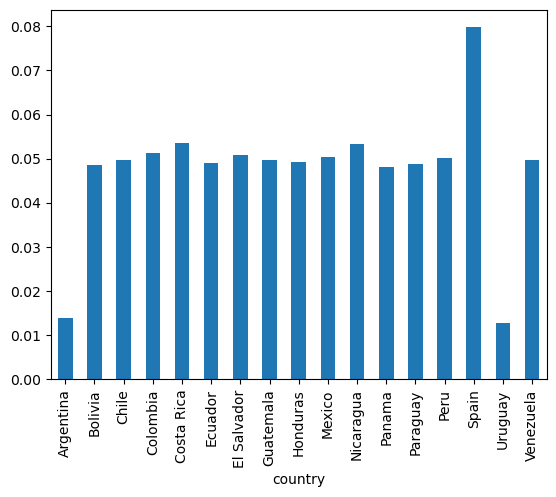

In [11]:
# Check conversion tate amoung countries
df_all.groupby("country")["conversion"].mean().plot.bar()

In [12]:
import scipy
df_dropSpan = df_all[df_all["country"] != "Spain"]
scipy.stats.ttest_ind(df_dropSpan[df_dropSpan["test"] == 0]["conversion"], df_dropSpan[df_dropSpan["test"] == 1]["conversion"])

Ttest_indResult(statistic=7.422512095954769, pvalue=1.15144687852198e-13)

### note : 
 1. Situation seems valid. Howevwe, the experimental design should be check. 
 2. Conversion Rate in Argentina & Uruguary .
 

#  Experimental Design

In [13]:
len(df_dropSpan)

401539

In [14]:
len(df_dropSpan["user_id"].unique())

401539

In [15]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [16]:
# Full Variables
"""
columns2dummy = ["sex"]
columns2onehot = ["source", "country", "ads_channel", "browser"]
columns2label = ["date"]

x = df_dropSpan.copy().dropna().reset_index(drop = True)
y = x["test"]
x = x.drop(["test", "user_id", "device"], axis = 1)

for i in x.columns:
    # To Dummy
    if i in columns2dummy:
        x = pd.concat([x, pd.get_dummies(x[i]).iloc[:,0]], axis = 1)
        x = x.drop(i, axis = 1)
    # One-hot
    elif i in columns2onehot:
        x = pd.concat([x, pd.get_dummies(x[i])], axis = 1)
        x = x.drop(i, axis = 1)
    # Label
    elif i in columns2label:
        x[i] = labelencoder.fit_transform(x[i])
        print(f"{i} -> {labelencoder.classes_}")
    else:
        continue
# Drop Ads
x = x.drop("Ads", axis = 1)
# Create ES Dummy
x = pd.concat([x,pd.get_dummies(x["browser_language"])["ES"]], axis = 1)
x = x.drop("browser_language", axis = 1)    
"""

'\ncolumns2dummy = ["sex"]\ncolumns2onehot = ["source", "country", "ads_channel", "browser"]\ncolumns2label = ["date"]\n\nx = df_dropSpan.copy().dropna().reset_index(drop = True)\ny = x["test"]\nx = x.drop(["test", "user_id", "device"], axis = 1)\n\nfor i in x.columns:\n    # To Dummy\n    if i in columns2dummy:\n        x = pd.concat([x, pd.get_dummies(x[i]).iloc[:,0]], axis = 1)\n        x = x.drop(i, axis = 1)\n    # One-hot\n    elif i in columns2onehot:\n        x = pd.concat([x, pd.get_dummies(x[i])], axis = 1)\n        x = x.drop(i, axis = 1)\n    # Label\n    elif i in columns2label:\n        x[i] = labelencoder.fit_transform(x[i])\n        print(f"{i} -> {labelencoder.classes_}")\n    else:\n        continue\n# Drop Ads\nx = x.drop("Ads", axis = 1)\n# Create ES Dummy\nx = pd.concat([x,pd.get_dummies(x["browser_language"])["ES"]], axis = 1)\nx = x.drop("browser_language", axis = 1)    \n'

In [17]:
columns2dummy = ["device","sex"]
columns2onehot = ["source", "country"]
columns2label = ["date"]

x = df_dropSpan.copy().dropna().reset_index(drop = True)
y = x["test"]
x = x.drop(["test", "user_id", "ads_channel", "browser"], axis = 1)

for i in x.columns:
    # To Dummy
    if i in columns2dummy:
        x = pd.concat([x, pd.get_dummies(x[i]).iloc[:,0]], axis = 1)
        x = x.drop(i, axis = 1)
    # One-hot
    elif i in columns2onehot:
        x = pd.concat([x, pd.get_dummies(x[i])], axis = 1)
        x = x.drop(i, axis = 1)
    # Label
    elif i in columns2label:
        x[i] = labelencoder.fit_transform(x[i])
        print(f"{i} -> {labelencoder.classes_}")
    else:
        continue

# Create ES Dummy
x = pd.concat([x,pd.get_dummies(x["browser_language"])["ES"]], axis = 1)
x = x.drop("browser_language", axis = 1)    

date -> ['2015-11-30' '2015-12-01' '2015-12-02' '2015-12-03' '2015-12-04']


In [18]:
x

,date,conversion,age,Ads,Direct,SEO,Mobile,F,Argentina,Bolivia,...,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Uruguay,Venezuela,ES
0,4,0,21.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,3,0,22.0,1,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,19.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3,0,22.0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,4,0,35.0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401080,2,0,20.0,1,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
401081,4,0,50.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
401082,1,0,20.0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
401083,4,0,21.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
from sklearn import ensemble,  metrics
RANDOM_STATE = 123

In [20]:
# RF Modeling
Forest = ensemble.RandomForestClassifier(
    n_estimators = 100, oob_score = True, 
    random_state = RANDOM_STATE, 
    criterion = "entropy",
    max_depth = 10
)
forest_fit = Forest.fit(x, y)
pred = Forest.predict(x)


In [21]:
# Score
print(f"Train Acc = {100*metrics.accuracy_score(y,  pred):.2f}%. ")
print(f"Oob Score = {100*forest_fit.oob_score_:.2f}%. ")

Train Acc = 57.71%. 
Oob Score = 53.93%. 


<AxesSubplot:>

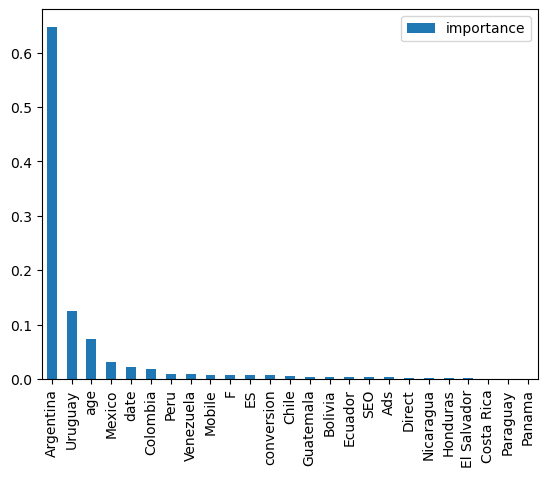

In [22]:
df_importance = pd.DataFrame(index = Forest.feature_names_in_, columns = ["importance"],
             data = Forest.feature_importances_)
df_importance.sort_values("importance", ascending = False).plot.bar()

# Further Check

<AxesSubplot:xlabel='country'>

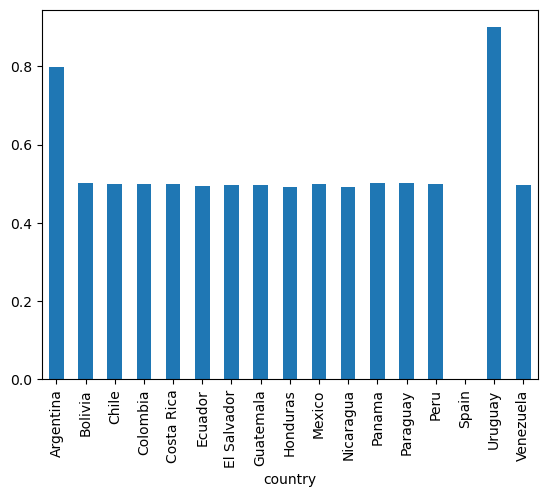

In [23]:
# Check test rate amoung countries
df_all.groupby("country")["test"].mean().plot.bar()

In [24]:
print("Test Rate in Uruguay : ")
print(f"{100* df_all[df_all['country'] == 'Uruguay']['test'].sum()/len(df_all[df_all['country'] == 'Uruguay']):.2f}%")
print("Test Rate in Argentina : ")
print(f"{100* df_all[df_all['country'] == 'Argentina']['test'].sum()/len(df_all[df_all['country'] == 'Argentina']):.2f}%")

Test Rate in Uruguay : 
89.96%
Test Rate in Argentina : 
79.98%


In [25]:
# Ttest without Abnorma Countries
_df = df_all[~df_all.country.isin(["Spain", "Argentina", "Uruguay"])]
scipy.stats.ttest_ind(_df[_df["test"] == 0]["conversion"], _df[_df["test"] == 1]["conversion"])

Ttest_indResult(statistic=-0.31810128971456436, pvalue=0.7504082947797941)

<bound method Axes.bar of <AxesSubplot:xlabel='age'>>

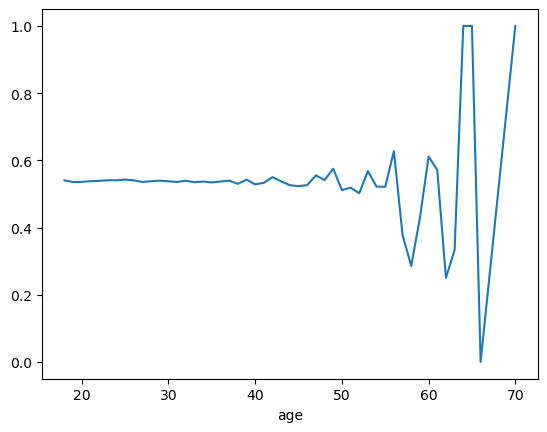

In [26]:
# Check Age
df_dropSpan.groupby("age")["test"].mean().plot().bar

In [27]:
print(len(df_dropSpan[df_dropSpan["age"]>55]))

177


In [28]:
df_abnormal = df_all[df_all.country.isin(["Argentina", "Uruguay"])]

#report = ProfileReport(df_abnormal.drop("user_id", axis = 1))
#report.to_file("df_abnormal.html")